# Qiskit Terra 0.6 Release Overview
Ali Javadi-Abhari, 19-Sep-18

## 1. Upgrading to 0.6

This notebook contains information to ease your transition to Qiskit Terra 0.6. This is done through code examples.

From a high-level point of view, the key updates of this release are in the low-level datastructures that are used by Qiskit to send jobs to backends. This format is called ``Qobj``. It allows us to better validate the different parts of the stack, localize errors, and emit more meaningful error messages. It also standardizes the development interfaces going forward.

The other key update is in how the backend providers work, which has been greatly simplified. Now the default providers available from Qiskit are `Aer` (for local) and `IBMQ` (for remote).

There are a set of breaking changes and a set of nice convenience features which we highlight below.

## 2. Working with local simulators (Aer)

The Qiskit element of Aer is responsible for providing a suite of simulators. The backends that you get by loading Aer are returned via `Aer.backends()`. 

Now that the provider of backends are explicit, the simulator names have been shortened.
`local_qasm_simulator` is now `qasm_simulator`, and so on.

In [1]:
from qiskit import *
Aer.backends()

[<QasmSimulator('qasm_simulator') from Aer()>,
 <QasmSimulatorPy('qasm_simulator_py') from Aer()>,
 <StatevectorSimulator('statevector_simulator') from Aer()>,
 <StatevectorSimulatorPy('statevector_simulator_py') from Aer()>,
 <UnitarySimulator('unitary_simulator') from Aer()>,
 <CliffordSimulator('clifford_simulator') from Aer()>]

## 3. Working with remote backends (IBMQ)

Authenticating your credentials on IBMQ is now easier. You can store your credentials once, and then simply type `IBMQ.load_accounts()` anytime you want access to remote IBM Q backends. This will load all the backends you have access to. No more `import Qconfig` in all of your scripts (the old way still works, for the time being).

For this to work, you have to have called `IBMQ.save_account('YOUR_TOKEN')` at some point in the past, which saves those credentials on your local machine.

Also, if you have access to the IBM Q Network backends, please note that we are deprecating the passing of ``hub``, ``group`` and ``project`` as separate arguments. Instead, they are absorbed as part of the url. So you will do something like: 

`IBMQ.save_account('YOUR_TOKEN', 'https://q-console-api.mybluemix.net/api/Hubs/YOUR_HUB/Groups/YOUR_GROU/Projects/YOUR_PROJECT')`

In [2]:
IBMQ.load_accounts()
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx5') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>,
 <IBMQBackend('ibmq_20_tokyo') from IBMQ(ibm-q-internal, development, qiskit-core)>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ(ibm-q-internal, development, qiskit-core)>]

Getting the status and configuration of a backend is now done via methods on the backend object, rather than through the object's properties. This simply means insert parenthesis at the end of the call.

In [3]:
from pprint import pprint
backend_name = 'ibmqx4'
backend = IBMQ.get_backend(backend_name)
backend.status()

{'pending_jobs': 22, 'name': 'ibmqx4', 'operational': True}

In [4]:
backend.configuration()

{'allow_q_object': False,
 'basis_gates': 'u1,u2,u3,cx,id',
 'chip_name': 'Raven',
 'coupling_map': [[1, 0], [2, 0], [2, 1], [3, 2], [3, 4], [4, 2]],
 'deleted': False,
 'description': '5 qubit transmon bowtie chip 3',
 'gate_set': 'SU2+CNOT',
 'internal_id': '5ae875670f020500393162b3',
 'local': False,
 'n_qubits': 5,
 'name': 'ibmqx4',
 'online_date': '2017-09-18T00:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx4',
 'version': '1.2.0'}

The methods `backend.calibration()` and `backend.parameters()` have been deprecated. We now just have `backend.properties()`, which will contain a merge of the previous dictionaries.

In [5]:
backend.properties()

{'backend': 'ibmqx4',
 'fridge_parameters': {'Temperature': {'date': '-', 'unit': '-', 'value': []},
  'cooldownDate': '2017-09-07'},
 'last_update_date': '2018-10-08T10:01:48.000Z',
 'multi_qubit_gates': [{'gateError': {'date': '2018-10-08T10:01:48Z',
    'value': 0.03658313664371693},
   'name': 'CX1_0',
   'qubits': [1, 0],
   'type': 'CX'},
  {'gateError': {'date': '2018-10-08T10:01:48Z',
    'value': 0.026637945836152227},
   'name': 'CX2_0',
   'qubits': [2, 0],
   'type': 'CX'},
  {'gateError': {'date': '2018-10-08T10:01:48Z', 'value': 0.03863525077896582},
   'name': 'CX2_1',
   'qubits': [2, 1],
   'type': 'CX'},
  {'gateError': {'date': '2018-10-08T10:01:48Z', 'value': 0.05946126929500478},
   'name': 'CX3_2',
   'qubits': [3, 2],
   'type': 'CX'},
  {'gateError': {'date': '2018-10-08T10:01:48Z', 'value': 0.03925146226082343},
   'name': 'CX3_4',
   'qubits': [3, 4],
   'type': 'CX'},
  {'gateError': {'date': '2018-10-08T10:01:48Z', 'value': 0.05080363825395476},
   'name': '

You can also filter the backends by least busy queue to speed up your work:

In [6]:
from qiskit.backends.ibmq import least_busy
devices = IBMQ.backends(simulator=False)
least_busy_device = least_busy(devices)
least_busy_device.status()

{'pending_jobs': -1, 'name': 'ibmq_20_tokyo', 'operational': True}

Finally, using the ``backend.jobs()`` and ``backend.retrieve_job(job_id)`` methods, you may now retrieve previous jobs executed on a particular backend (a batch of recent jobs, or a particular job). This allows you to resume your work even when a session is terminated.

In [7]:
last_10_jobs = least_busy_device.jobs(limit=10)
for j in last_10_jobs:
    print(j.job_id())

5bbab4081e05e30056b929e3
5b98c1bb407d8700388c07d2
5b98685149bc8a003ac0c676
5b986818407d8700388c07a6
5b98679a0fb2bf003b41eb74
5b98676e14c0ea003b36579b
5b9866f3be0bed00448ea229
5b934172e5b8fb0039341344
5b9340141ac3ce0038641f4c
5b933ffb307f03003894b0bc


## 4. Building and Executing Circuits

Creating a circuit works the same as v0.5. Note that you cannot use the ``QuantumProgram`` module anymore. Instead of emitting deprecation warnings, the ``QuantumProgram`` module is now fully removed.

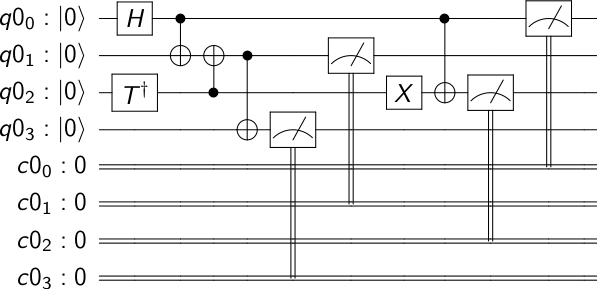

In [8]:
from qiskit.tools.visualization import circuit_drawer
qr = QuantumRegister(4)
cr = ClassicalRegister(4)
circ = QuantumCircuit(qr, cr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.tdg(qr[2])
circ.cx(qr[2], qr[1])
circ.x(qr[2])
circ.cx(qr[0], qr[2])
circ.cx(qr[1], qr[3])
circ.measure(qr, cr)
circuit_drawer(circ, scale=0.5)

A new matplotlib-based circuit drawer provides an alternative to the latex circuit drawer above, for users who had difficulty installing the latex drawer's pre-requisites. The drawer falls back to this if the latex fails.

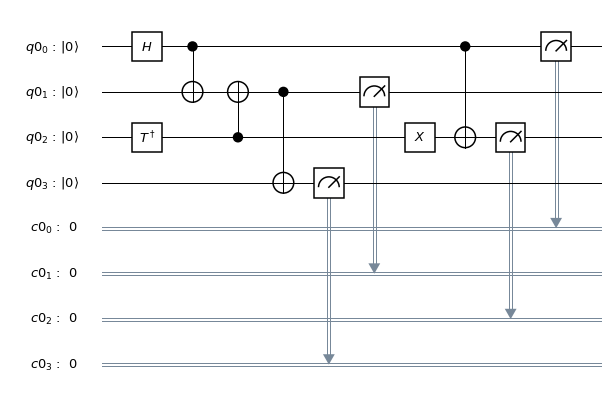

In [9]:
%matplotlib inline
qiskit.tools.visualization.matplotlib_circuit_drawer(circ)

Executing a circuit on a backend works as before. However, the Job interface has been simplified. If you want to explicitly check the status of a job, you can do so with the status method (note that this used to be a property, so again don't forget the parenthesis).
You can query the status, which gives you an enum of qiskit.backends.JobStatus (`queued`, `running`,
`validating`, `done` or `cancelled`).

In [10]:
simulator_backend = IBMQ.get_backend(simulator=True, hub=None)
job = execute(circ, simulator_backend)

import time
from qiskit.backends import JobStatus
print(job.status())
while job.status() != JobStatus.DONE:
    time.sleep(1)
    print(job.status())

JobStatus.INITIALIZING
JobStatus.INITIALIZING
JobStatus.RUNNING
JobStatus.DONE


## 5. Compile() improvements, and new Qobj format

The compiler code has been optimized for better performance by removing some bottlenecks. Also, if you have many circuits, they will compile in parallel, giving you noticeable improvements (proportional to the number of physical cores on your machine).

In Qiskit, the output of the ``compile()`` command is called ``Qobj``. It is a container for the job to be executed on the backend, and can include multiple circuits within it. It specifies the details of the experiment that a backend needs to know in order to run the job, such as number of shots, the device registers that should be used for measurement, etc. A major feature of this release is the definition of a set of specifications to allow us to validate these kinds of jobs for correctness, and to localize errors better.

You can convert a qobj back to (a list of) QuantumCircuit in order to see how the circuit got transformed during the compilation process.

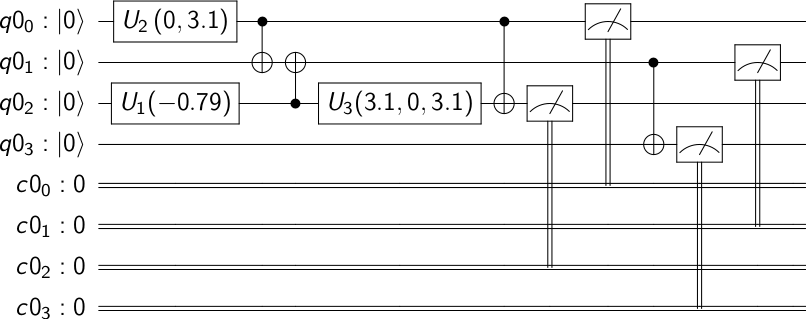

In [11]:
qobj = compile(circ, simulator_backend)
compiled_circ = qobj_to_circuits(qobj)[0]
circuit_drawer(compiled_circ, scale=0.5)

To inspect qobj further, you can print it as a JSON dictionary. This is the dictionary sent over the network to remote backends.

In [12]:
qobj.as_dict()

{'config': {'max_credits': 10,
  'memory_slots': 4,
  'n_qubits': 4,
  'shots': 1024},
 'experiments': [{'config': {'basis_gates': 'u1,u2,u3,cx,id',
    'coupling_map': 'all-to-all',
    'layout': None,
    'memory_slots': 4,
    'n_qubits': 4},
   'header': {'clbit_labels': [['c0', 4]],
    'compiled_circuit_qasm': 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q0[4];\ncreg c0[4];\nu1(-0.785398163397448) q0[2];\nu2(0,3.14159265358979) q0[0];\ncx q0[0],q0[1];\ncx q0[2],q0[1];\ncx q0[1],q0[3];\nmeasure q0[1] -> c0[1];\nmeasure q0[3] -> c0[3];\nu3(3.14159265358979,0,3.14159265358979) q0[2];\ncx q0[0],q0[2];\nmeasure q0[0] -> c0[0];\nmeasure q0[2] -> c0[2];\n',
    'name': 'circuit1',
    'number_of_clbits': 4,
    'number_of_qubits': 4,
    'qubit_labels': [['q0', 0], ['q0', 1], ['q0', 2], ['q0', 3]]},
   'instructions': [{'name': 'u1',
     'params': [-0.7853981633974483],
     'qubits': [2],
     'texparams': ['- \\frac{\\pi}{4}']},
    {'name': 'u2',
     'params': [0.0, 3.14159265358979

The compiled Qobj can be directly run on a backend.

In [13]:
job = simulator_backend.run(qobj)
result = job.result()

## 6. Better Jupyter tools

The new release contains several improvements to the user experience while using Jupyter notebooks.

### a) Jupyter magics

Cell magics are special Jupyter command that you insert at the beginning of a cell, which give you useful information when you compile and execute in Qiskit.

In [14]:
import qiskit.wrapper.jupyter

The ``%%qiskit_job_status`` magic prints and automatically updates the status of a submitted job until the job has finished running. This way you don't have to manually check for the job status.

In [15]:
%%qiskit_job_status
job = execute(circ, backend)

A Jupyter Widget

In [16]:
%%qiskit_progress_bar
qobj = compile(circ, backend)

### b) New Interactive Visualizations

The new release has improved, interactive visualizations of quantum states and measurement count histograms. These will be used by default when the environment is Jupyter and an internet connection exists. Otherwise, it falls back to the old static plots.

In [20]:
from qiskit import *
from qiskit.tools.visualization.interactive import *
q = QuantumRegister(5)
circ1 = QuantumCircuit(q)
circ1.h(q)
circ1.ry(1.3, q[0])
circ1.cx(q[0], q[1])

In [ ]:
statevector_simulator = Aer.get_backend('statevector_simulator')
result = execute(circ1, statevector_simulator).result()
psi = result.get_statevector()
iplot_state(psi, method='qsphere') # method could be city, paulivec, qsphere, bloch, wigner
# Not displayable in github

In [ ]:
c = ClassicalRegister(5)
circ2 = QuantumCircuit(q, c)
circ2.h(q)
circ2.measure(q, c)
circ3 = QuantumCircuit(q, c)
circ3.h(q[0])
circ3.y(q[1])
circ3.cx(q[1], q[0])
circ3.measure(q, c)

qasm_simulator = Aer.get_backend('qasm_simulator')
result = execute([circ2, circ3], qasm_simulator).result()
counts_list = [result.get_counts(circ) for circ in [circ2, circ3]]
# Needs to be run in Jupyter, will not render on github
iplot_histogram(counts_list, legend=['first circuit', 'second circuit'])
# Not displayable in github